In [1]:
# %load_ext autoreload
# %autoreload 2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_NQueens, plot_evolution

# Local Search: Genetic Algorithm

## 1.Genrating Phrases

In this section we consider a toy problem: generating a target phrases (e.g. "genetic algorithm") from an initial polupation of random strings. Assume the length of the target is known.

Problem Formulation: 

1. Direct Representation: just strings.
2. Exponential Search Space: $m^l$ where $m$ is the size of the alphabet (set of characters in our interest) and $l$ is the length of the string.

Now that we want to solve it with GA:
1. Chromesome: directly use the string itself.
2. Fitness: how match/close an individual is to the target.
3. Mating: combine two strings in someway to generate a new one.

The following cells will walk you through this problem to show the basic idea of GA

In [2]:
# setting up the problem
target = 'Genetic Algorithm'
u_case = [chr(x) for x in range(65, 91)]
l_case = [chr(x) for x in range(97, 123)]
gene_pool = u_case + l_case + [' '] # all English chracters and white space

def init_population(pop_size, gene_pool, state_length):
    """
    Randomly initialize a population for genetic algorithm
        pop_size  :  Number of individuals in population
        gene_pool   :  List of possible values for individuals
        state_length:  The length of each individual
    """

    population = []
    for _ in range(pop_size):
        new_individual = "".join(random.choices(gene_pool, k=state_length))
        population.append(new_individual)

    return population

# test
init_pop = init_population(10, gene_pool, len(target))
init_pop

['laDiCBBVdBGYoNxrg',
 'KyIiFNaxtWTsgWpjo',
 'YHoFwmbiLdgQMUzkF',
 'DhFjqkBlCQhmuQAAX',
 'DUMFcQxGsjd ebqak',
 'BFWMGxykynTHeeIDo',
 'oE wJRLjxaiLfLxMz',
 'xYwEcHrSKbHCaDJVi',
 'ZkosodOgrLRoCBGCZ',
 'ynFbXnYKSawgUASoH']

In [3]:
def fitness_fn(sample):
    # TODO: evaluate how close *sample* is to the target
    return sum([1 if sample[i] == target[i] else 0 for i in range(len(target))])

# test
for sample in init_pop:
    f = fitness_fn(sample)
    print(f)


0
0
1
0
0
0
0
0
1
0


In [4]:
def select(r, population, fitness_fn):
    """
    TODO: select *r* samples from *population*
    the simplest choice is to sample from *population* with each individual weighted by its fitness
    """
    fitnesses = [fitness_fn(sample) for sample in population]
    return random.choices(population, weights=fitnesses, k=r)

# test
parents = select(2, init_pop, fitness_fn)
parents

['YHoFwmbiLdgQMUzkF', 'YHoFwmbiLdgQMUzkF']

In [5]:
def recombine(x, y):
    """
    TODO: combine two parents to produce an offspring
    """
    n = len(x)
    c = random.randrange(0, n)
    return x[:c] + y[c:]

def mutate(x, gene_pool, pmut):
    """
    apply mutation to *x* by randomly replacing one of its gene from *gene_pool*
    """
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + new_gene + x[c + 1:]

# test
child = mutate(recombine(*parents), gene_pool, 0.1)
child

'YHoFwmbiLdgQMUzkF'

In [6]:
# now refactor things into a *Problem* abstraction
# you can directly reuse what you have implemented above
from abc import ABC, abstractmethod

class GAProblem(ABC):
    @abstractmethod
    def init_population(self, pop_size): pass

    @abstractmethod
    def fitness(self, sample): pass

    @abstractmethod
    def reproduce(self, population): pass

    @abstractmethod
    def replacement(self, old, new): pass

class PhraseGeneration(GAProblem):
    def __init__(self, target, alphabet):
        self.target = target
        self.alphabet = alphabet
        self.max_fitness = len(target)

    def init_population(self, pop_size):
        # raise NotImplementedError()
        return init_population(pop_size, self.alphabet, len(self.target))

    def fitness(self, sample):
        # TODO: evaluate how close *sample* is to the target
        return fitness_fn(sample)
    
    def reproduce(self, population, mutation_rate):
        """
        TODO: generate the next generation of population

        hint: make a new individual with 
        
        mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)

        """
        new_population = []
        for _ in range(len(population)):
            x = mutate(recombine(*select(2, population, self.fitness)), self.alphabet, mutation_rate)
            new_population.append(x)
        return new_population
    
    def replacement(self, old, new):
        """
        You can use your own strategy, for example retain some solutions from the old population
        """
        pop_size = len(old)
        elites = sorted(old, key=self.fitness, reverse=True)[:3]
        best_children = sorted(new, key=self.fitness, reverse=True)[:pop_size - 3]
        return elites + best_children
        

def genetic_algorithm(
        problem: GAProblem, 
        ngen, n_init_size, mutation_rate, 
        log_intervel=100
    ):

    population = problem.init_population(n_init_size)
    best = max(population, key=problem.fitness)
    history = [(0, list(map(problem.fitness, population)))]

    for gen in range(ngen):
        next_gen    = problem.reproduce(population, mutation_rate)
        population  = problem.replacement(population, next_gen)

        if gen % log_intervel == 0:
            current_best = max(population, key=problem.fitness)
            if problem.fitness(current_best) > problem.fitness(best): best = current_best
            print(f"Generation: {gen}/{ngen},\tBest: {best},\tFitness={problem.fitness(best)}")         
            history.append((gen, list(map(problem.fitness, population))))
    
    history.append((ngen-1, list(map(problem.fitness, population))))
    return best, history

In [7]:
# now set up the parameters
ngen = 1200
max_population = 120
mutation_rate = 0.08

sid = "Test Message"
target = f"Genetic Algorithm by {sid}" 
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz "

problem = PhraseGeneration(target, alphabet)

# and run it
solution, history = genetic_algorithm(problem, ngen, max_population, mutation_rate)
solution

Generation: 0/1200,	Best: bDYBljEUvTFhrApLVusoiiSptCoedwsle,	Fitness=4
Generation: 100/1200,	Best: GeGetic VlqhrAmhmjpybFeatCFessaZe,	Fitness=19
Generation: 200/1200,	Best: Genetic AlqhrAmhmjsy TeatCFessage,	Fitness=24
Generation: 300/1200,	Best: Genetic AlghrAUhmjsy TestCFessage,	Fitness=26
Generation: 400/1200,	Best: Genetic AlgorAthm by TestCFessage,	Fitness=30
Generation: 500/1200,	Best: Genetic AlgorAthm by TestCFessage,	Fitness=30
Generation: 600/1200,	Best: Genetic AlgorAthm by Test Nessage,	Fitness=31
Generation: 700/1200,	Best: Genetic Algorithm by Test Message,	Fitness=33
Generation: 800/1200,	Best: Genetic Algorithm by Test Message,	Fitness=33
Generation: 900/1200,	Best: Genetic Algorithm by Test Message,	Fitness=33
Generation: 1000/1200,	Best: Genetic Algorithm by Test Message,	Fitness=33
Generation: 1100/1200,	Best: Genetic Algorithm by Test Message,	Fitness=33


'Genetic Algorithm by Test Message'

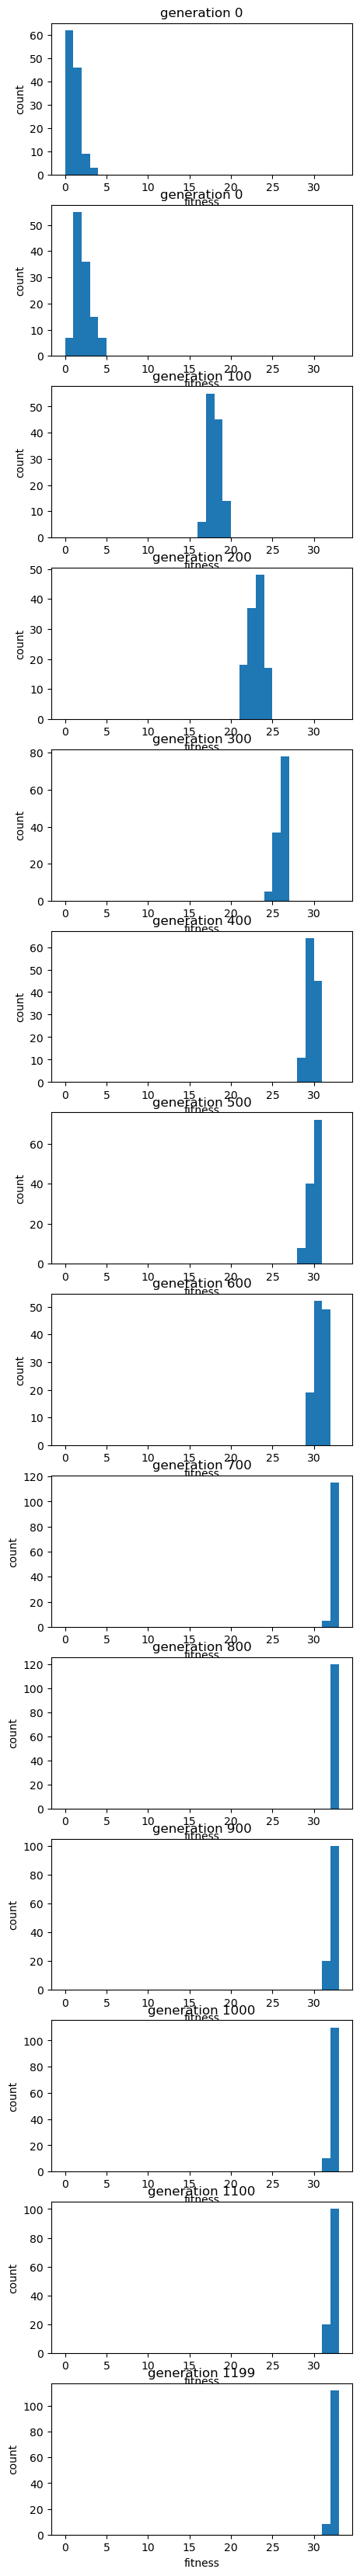

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33.])

In [8]:
# visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness+1)
plot_evolution(history, bins)
bins

## 2. N-Queens Problem

It is possible to solve the N-Queens problem with slight modifications.

For the problem:

1. Direct Representation: placement of queens.
2. Search Space: $n^n$, if we don't use any constraints.

To use GA:

Actually a new fitness function is the minimum modification you need for this problem.

Others are alomost the same as the previous problem.

In [9]:
class NQueensProblem(GAProblem):
    def __init__(self, n):
        self.n = n
        self.max_fitness =  n*(n-1)//2 # max number if non-attacking pairs
        self.alphabet = list(range(n))

    def init_population(self, pop_size):
        population = []
        for _ in range(pop_size):
            individual = list(np.random.permutation(self.n))
            population.append(individual)
        return population
     
    def fitness(self, queens):
        non_attacking_pairs = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                if abs(queens[i] - queens[j]) != abs(i - j):
                    non_attacking_pairs += 1
        return non_attacking_pairs

    def reproduce(self, population, mutation_rate):
        new_population = []
        pop_len = len(population)
        for _ in range(pop_len):
            # select two parents (select handles weighting)
            parent1, parent2 = select(2, population, self.fitness)
            n = self.n
            # order crossover (choose two cut points)
            a = random.randrange(0, n)
            b = random.randrange(0, n)
            if a > b:
                a, b = b, a
            child = [-1] * n
            # copy slice from parent1
            child[a:b+1] = parent1[a:b+1]
            # fill remaining positions from parent2 in order, skipping duplicates
            fill_pos = 0
            for gene in parent2:
                if gene in child:
                    continue
                # find next empty slot
                while child[fill_pos] != -1:
                    fill_pos += 1
                child[fill_pos] = gene
            # swap mutation
            if random.uniform(0, 1) < mutation_rate:
                i = random.randrange(0, n)
                j = random.randrange(0, n)
                child[i], child[j] = child[j], child[i]

            new_population.append(child)
        return new_population

    def replacement(self, old, new):
        pop_size = len(old)
        k = min(3, pop_size)
        elites = sorted(old, key=self.fitness, reverse=True)[:k]
        best_children = sorted(new, key=self.fitness, reverse=True)[:pop_size - k]
        return elites + best_children

    def __repr__(self):
        return f"{self.n}-Queens Problem"


In [10]:
from utils import plot_NQueens
ngen = 1000
init_size = 120
mutation_rate = 0.08

n = 8
problem = NQueensProblem(n)
solution, history = genetic_algorithm(problem, ngen, init_size, mutation_rate)

Generation: 0/1000,	Best: [3, 6, 0, 2, 4, 1, 7, 5],	Fitness=27
Generation: 100/1000,	Best: [4, 2, 7, 3, 6, 0, 5, 1],	Fitness=28
Generation: 200/1000,	Best: [4, 2, 7, 3, 6, 0, 5, 1],	Fitness=28
Generation: 300/1000,	Best: [4, 2, 7, 3, 6, 0, 5, 1],	Fitness=28
Generation: 400/1000,	Best: [4, 2, 7, 3, 6, 0, 5, 1],	Fitness=28
Generation: 500/1000,	Best: [4, 2, 7, 3, 6, 0, 5, 1],	Fitness=28
Generation: 600/1000,	Best: [4, 2, 7, 3, 6, 0, 5, 1],	Fitness=28
Generation: 700/1000,	Best: [4, 2, 7, 3, 6, 0, 5, 1],	Fitness=28
Generation: 800/1000,	Best: [4, 2, 7, 3, 6, 0, 5, 1],	Fitness=28
Generation: 900/1000,	Best: [4, 2, 7, 3, 6, 0, 5, 1],	Fitness=28


d:\wendy\study\2025-2026Fall\人工智能\lab\lab08\Practice8\utils.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


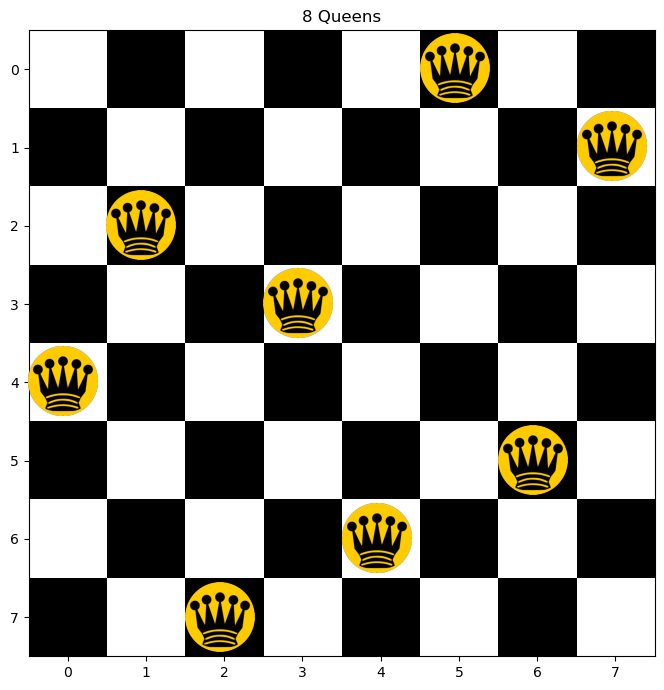

In [11]:
# Example of how to use this function
# plot_NQueens([4, 2, 0, 6, 1, 7, 5, 3])
# replace the parameter with your own results
from utils import plot_NQueens
plot_NQueens(solution)

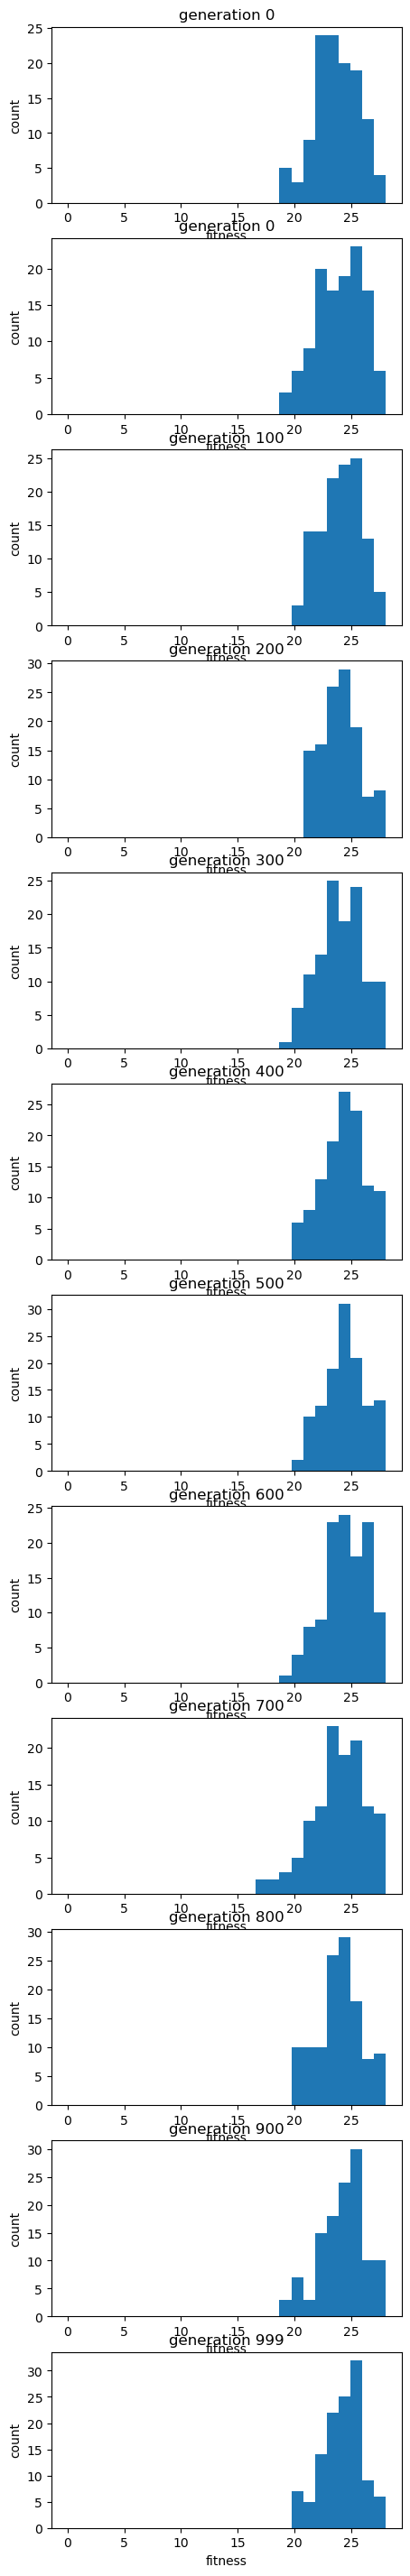

In [12]:
# Visualize the evolution of the polulation
bins = np.linspace(0, problem.max_fitness, problem.max_fitness)
plot_evolution(history, bins)